In [3]:
# !pip install tensorflow==2.12.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 9.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 11.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Ge

In [ ]:
#  Steps of the work:

# Make a model with accessible parameters using TensorFlow 2.x
# Write an entropy loss and add it to the network parameters for training.
# Train a model by jointly optimizing its loss (e.g. cross entropy for classification) and the entropy for compressability.
# Compress the model parameters using Huffman coding.
# Analyze the results and trade-off between accuracy and compressability.
# Write a model wrapper that can read and write the compressed parameters.

# Notes:

# Can be started on simple datasets like MNIST.
# Can start from simple MLP NNs. And then extend to convs. The implementation should be generic enough so that it can support any layer.
# Bonus: add support for normalization layers: batch norm, instance norm, etc.

In [4]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
# generate a simple NN model

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

    
kernel_initializer = 'he_normal'
activation = "relu"

def get_model(chs=256):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model



In [22]:
model.layers

In [23]:
model.layers[0]

In [25]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(784, 256) dtype=float32, numpy=
 array([[ 0.04747557, -0.0241543 ,  0.06825899, ..., -0.06088347,
         -0.01428646,  0.09181509],
        [ 0.01840485, -0.08634035, -0.05705916, ...,  0.06484796,
         -0.08538831, -0.06986799],
        [ 0.08091406,  0.09522551,  0.06740516, ..., -0.02281002,
          0.06427108, -0.05539102],
        ...,
        [ 0.0265468 , -0.02665523,  0.01700675, ..., -0.02849575,
          0.06601989,  0.06358932],
        [ 0.01959939, -0.0224366 ,  0.00977207, ..., -0.00086983,
          0.11475715, -0.05219548],
        [ 0.01873984,  0.05438872, -0.04925571, ...,  0.08855245,
          0.06425571,  0.05567208]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.01938667, -0.02402712, -0.02026186, -0.01597225, -0.01930892,
        -0.02138305, -0.02111024, -0.01609827, -0.01176102, -0.01660232,
        -0.01214598, -0.02503965, -0.00847238, -0.01553644, -0.02141835,
    

In [97]:
tf.reduce_sum(np.arange(100).reshape((10,10)), axis=0, keepdims=True)



<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[450, 460, 470, 480, 490, 500, 510, 520, 530, 540]])>

In [149]:
def calculate_entropy_range(variables, scale=3):
    
    std = tf.math.reduce_variance(variables)**0.5
    if std==0.0:
        std = 1.0
    mean = tf.math.reduce_mean(variables)
#     To estimate the histogram, we first remove outliers in the
# activations if the samples are outside the range [μ−3σ; μ+3σ],

    return mean - std*scale, mean + std*scale
    
bins = np.arange(256, dtype=np.float32)
bins = tf.convert_to_tensor(bins)
bins = tf.reshape(bins, (1,-1))

# def calculate_weights(variables, min_h, max_h):
# #    calculate weight δj,k
# #    Δ = 1/Nb.
# #    nodes t1 = 0, t2, ..., tNb = 1 uniformly filling the range [0; 1]

#     xk = 
#     tj = 
# #    if xk ∈ [tj−1; tj ] then (xk − tj−1)/Δ
#     if 
#         return 
# #     if xk ∈ [tj ; tj+1] then (tj+1 − xk)/Δ
#     elif:
#         return 
# #     otherwise.
#     else:
#         return 0
    
#     return -1
def calculate_weights(variables, min_h, max_h):
    nbins = len(variables)
    weights = tf.zeros(nbins)
    t = tf.linspace(0, 1, nbins)
    delta = 1 / nbins

    for j in range(nbins):
        for k in range(len(variables[j])):
            xk = variables[j][k]
            for i in range(nbins):
                tj = t[i]
                tj1 = t[max(0, i-1)]
                tj2 = t[min(nbins-1, i+1)]
                w = weight(xk, tj, tj1, tj2)
                weights[i] += w

    weights /= delta * len(variables[0])
    weights /= tf.experimental.numpy.max(weights)

    return weights

def weight(xk, tj, tj1, tj2):
#    if xk ∈ [tj−1; tj ] then (xk − tj−1)/Δ
#     if xk ∈ [tj ; tj+1] then (tj+1 − xk)/Δ
#     otherwise return 0
    delta = tj2 - tj1
    if delta == 0:
        return 0.0

    if tj1 <= xk <= tj:
        return (xk - tj1) / delta
    elif tj <= xk <= tj2:
        return (tj2 - xk) / delta
    else:
        return 0.0

def calculate_histogram(variables, min_h, max_h):
    flat_vars = tf.reshape(variables, (-1,1))
    scaled_vars = (flat_vars-min_h)*255/(max_h-min_h)
    
#     diff = bins - scaled_vars
    diff = calculate_weights(variables, min_h, max_h)
    p_ = tf.exp(-(diff**2))
    p = p_ / (tf.reduce_sum(p_, axis=1, keepdims=True)+1e-10)
    hist = tf.reduce_sum(p, axis=0)
    return hist
    
def calculate_entropy(variables, eps=1e-10):
    flat_vars = tf.reshape(variables, (-1,1))
    min_h, max_h = calculate_entropy_range(variables)
    
    hist = calculate_histogram(flat_vars, min_h, max_h)
    #hist = tf.histogram_fixed_width(flat_vars, [min_h,max_h])
    
    probs = hist / tf.reduce_sum(hist)
#     probs[probs == 0] = 1  # replace zeros with ones
    entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
#     print(entropy,':: ', np.min(flat_vars),':: ', np.max(flat_vars),':: ', bins[0],':: ',bins[1])
    return entropy, (min_h, max_h)


class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        entropy = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy

        return entropy
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)

        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))


In [150]:
np_h=np.histogram(model.layers[3].variables[0], bins=256)

In [151]:
min_h, max_h = calculate_entropy_range(model.layers[3].variables[0])
our_h=calculate_histogram(model.layers[3].variables[0], min_h, max_h)


TypeError: object of type 'ResourceVariable' has no len()

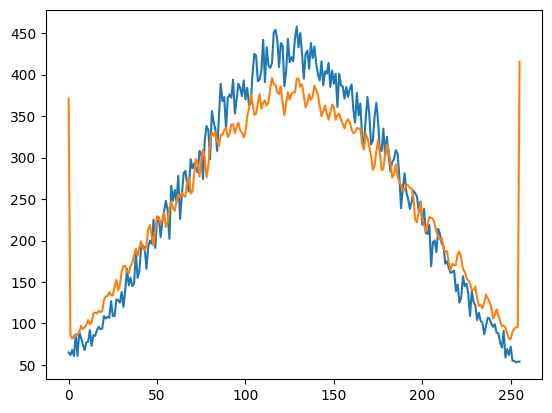

In [148]:
from matplotlib import pyplot as plt

plt.plot(np_h[0])
plt.plot(our_h)

In [123]:
# train the model
tf.config.run_functions_eagerly(True)
# check this out
# loss doesnt change
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)

   3/1875 [..............................] - ETA: 2:03:11 - loss: 27.7103

KeyboardInterrupt: 

In [53]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.02000000000001


In [56]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.61
